<a href="https://colab.research.google.com/github/Rhythm1821/Tensorflow-Face-Detection/blob/main/Face_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Detection Tensorflow

## 1 Setup and Data gathering

### 1.1 Install dependencies

In [1]:
pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


In [2]:
pip install albumentations

In [3]:
!pip install labelme
import labelme

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 23.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for onnxruntime>=1.14.1 from https://files.pythonhosted.org/packages/2f/e2/ced4e64433097cb14425098ce3c6200b83d226005e8c23ba5bac44c89ab9/onnxruntime-1.15.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.9 MB/s eta 0:00:00
  Obtaining dependency information for PyQt5-sip<13,>=12.11 from https://files.pythonhosted.org/packages/eb/49/8f4e882045ac9ddbf7e55c41ff0f07cdef57c52fdc877bd2d1552767827

### 1.2 Collect images using opencv

In [4]:
import os, uuid,time,cv2

In [5]:
# Create data folder
if not os.path.exists('data'):
  os.mkdir('data')

# if not os.path.exists('/content/data/images'):
#   os.mkdir('/content/data/images')
# if not os.path.exists('/content/data/labels'):
#   os.mkdir('/content/data/labels')

In [6]:
"""
Take images by running this in your local to get your images
IMAGES_PATH = os.path.join('content','data','images')
number_images = 30
cap = cv2.VideoCapture(0)
for img_num in range(number_images):
  print(f'Collecting image {img_num}')
  ret, frame = cap.read()
  imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
  cv2.imwrite(imgname,frame)
  cv2.imshow('frame',frame)
  time.sleep(0.5)

  if cv2.waitKey(1) & 0xFF==ord('q'):
    break

cap.release()
cv2.destroyAllWindows()]
"""

"\nTake images by running this in your local to get your images\nIMAGES_PATH = os.path.join('content','data','images')\nnumber_images = 30\ncap = cv2.VideoCapture(0)\nfor img_num in range(number_images):\n  print(f'Collecting image {img_num}')\n  ret, frame = cap.read()\n  imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')\n  cv2.imwrite(imgname,frame)\n  cv2.imshow('frame',frame)\n  time.sleep(0.5)\n\n  if cv2.waitKey(1) & 0xFF==ord('q'):\n    break\n\ncap.release()\ncv2.destroyAllWindows()]\n"

In [7]:
from zipfile import ZipFile
import requests
from pathlib import Path

data_path = Path('data/')
image_path = Path(data_path / 'images')
label_path = Path(data_path / 'labels')

if data_path.is_dir():
  print(f'{data_path} path already exists...')
else:
  print(f'Creating {data_path} path')
  data_path.mkdir(parents=True,exist_ok=True)

with open('images.zip','wb') as f:
  request = requests.get('https://github.com/Rhythm1821/Colab-Project-Data/raw/main/Face-Detection/images.zip')
  f.write(request.content)

with ZipFile('images.zip','r') as zip_ref:
  print('unzipping the data......')
  zip_ref.extractall(data_path)

with open('labels.zip','wb') as f:
  request = requests.get('https://github.com/Rhythm1821/Colab-Project-Data/raw/main/Face-Detection/labels.zip')
  f.write(request.content)

with ZipFile('labels.zip','r') as zip_ref:
  print('unzipping the data......')
  zip_ref.extractall(data_path)


data path already exists...
unzipping the data......
unzipping the data......


## 2 Review dataset and build image loading function

### 2.1 Import tf and Deps

In [8]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pyplot as plt

In [9]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

### 2.2 Load images into a tf data pipeline

In [10]:
images = tf.data.Dataset.list_files('/content/data/images/*.jpg')

In [11]:
images.as_numpy_iterator().next()

b'/content/data/images/9978a627-335d-11ee-9af2-7fd07a498e42.jpg'

In [12]:
def load_image(x):
  byte_img = tf.io.read_file(x)
  img = tf.io.decode_jpeg(byte_img)
  return img

In [13]:
images = images.map(load_image)

In [14]:
# images.as_numpy_iterator().next()

In [15]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.3 View raw images with Matplotlib

In [16]:
image_generator = images.batch(4).as_numpy_iterator() #batches images

In [17]:
plot_images = image_generator.next()

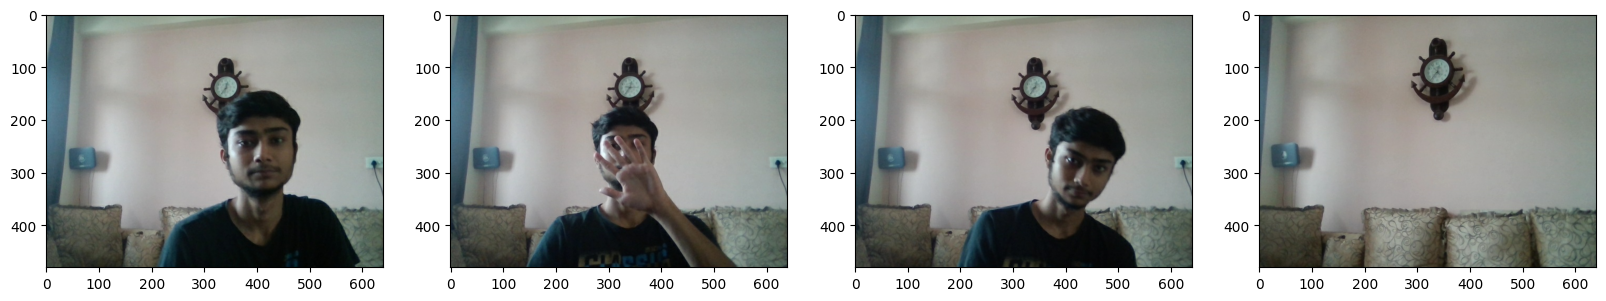

In [18]:
fig, ax = plt.subplots(ncols=4,figsize=(20,20))
for idx, image in enumerate(plot_images):
  ax[idx].imshow(image)
plt.show()

In [19]:
train_path = Path('data/train')
train_path.mkdir()
test_path = Path('data/test')
test_path.mkdir()
val_path = Path('data/val')
val_path.mkdir()
Path(train_path/'images').mkdir()
Path(train_path/'labels').mkdir()
Path(test_path/'images').mkdir()
Path(test_path/'labels').mkdir()
Path(val_path/'images').mkdir()
Path(val_path/'labels').mkdir()

## 3 Partition unaugmentated data

### 3.1 Manually split data into train, test, val

In [21]:
for folder in ['train','test','val']:
  for file in os.listdir(os.path.join('data',folder,'images')):
    filename = file.split('.')[0] + '.json'
    existing_filepath = os.path.join('data','labels',filename)
    if os.path.exists(existing_filepath):
      new_filepath = os.path.join('data',folder,'labels',filename)
      os.replace(existing_filepath,new_filepath)